In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from datetime import datetime
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", 
        color_codes=True, 
        font_scale = 2)

In [2]:
os.chdir('/Users/patrickrs/Documents/GitLab/patrick-steiner/03-Machine-Learning')

In [3]:
data = pd.read_csv("pirate_data.csv")
data = data.dropna(how = 'any')
data = data.drop(data.columns[0], axis = "columns")

In [4]:
data.head()

,DATETIME (LOCAL),DATETIME (UTC),DATE (LT),DATE (UTC),REGION,COUNTRY,INCIDENT TYPE,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIMEZONE,TIME OF DAY,ATTACKS,ATTACK SUCCESS
0,2016-01-30 23:34:00,2016-01-30 22:34:00,2016-01-30,2016-01-30,WEST AFRICA,NIGERIA,"FAILED ATTACK, HIJACKING",CONTAINER SHIP,0,OFF SHORE,3.000000,6.250000,Africa/Lagos,EVENING,1,0
1,2016-01-29 23:40:00,2016-01-29 22:40:00,2016-01-29,2016-01-29,WEST AFRICA,NIGERIA,KIDNAP/RANSOM AT SEA,PRODUCT TANKER,0,OFF SHORE,2.500000,5.750000,Africa/Lagos,EVENING,1,1
2,2016-01-28 03:00:00,2016-01-28 02:00:00,2016-01-28,2016-01-28,SOUTH ASIA,INDIA,"FAILED ATTACK, ROBBERY",PRODUCT TANKER,0,ANCHORAGE,22.816667,70.116667,Asia/Kolkata,NIGHT,1,0
4,2016-01-25 23:55:00,2016-01-25 22:55:00,2016-01-25,2016-01-25,SOUTH AMERICA,VENEZUELA,THEFT AT ANCHORAGE,GENERAL CARGO VESSEL,0,ANCHORAGE,10.267500,-63.432500,America/Caracas,EVENING,1,1
5,2016-01-25 01:30:00,2016-01-25 00:30:00,2016-01-25,2016-01-25,SOUTH ASIA,INDIA,ARMED ROBBERY AT SEA,PRODUCT TANKER,0,OFF SHORE,22.783333,70.033333,Asia/Kolkata,NIGHT,1,1


In [5]:
data['DATETIME (LOCAL)'] = pd.to_datetime(data['DATETIME (LOCAL)'])

In [6]:
data [['DATETIME (UTC)']] = pd.to_datetime(data['DATETIME (UTC)'])

In [7]:
data [['DATE (LT)']] = pd.to_datetime(data['DATE (LT)'])

In [8]:
data [['DATE (UTC)']] = pd.to_datetime(data['DATE (UTC)'])

In [9]:
data.dtypes

DATETIME (LOCAL)            datetime64[ns]
DATETIME (UTC)              datetime64[ns]
DATE (LT)                   datetime64[ns]
DATE (UTC)                  datetime64[ns]
REGION                              object
COUNTRY                             object
INCIDENT TYPE                       object
VESSEL TYPE                         object
MAERSK?                              int64
VESSEL ACTIVITY LOCATION            object
LAT                                float64
LONG                               float64
TIMEZONE                            object
TIME OF DAY                         object
ATTACKS                              int64
ATTACK SUCCESS                       int64
dtype: object

First thing to do is to cluster the geografical location:

In [42]:
d = data.dropna(axis = 0, 
                how ='any', 
                subset = ['LAT','LONG'], 
                inplace = False)

d = d.loc[:,['LAT','LONG']]

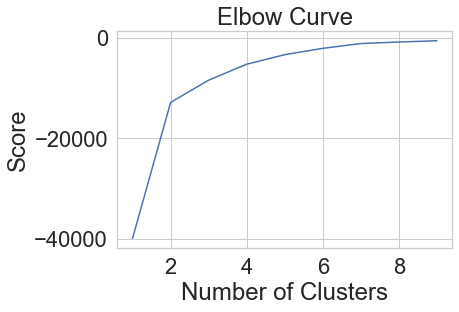

In [43]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = d[['LAT']]
X_axis = d[['LONG']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# Graphical analysis indicates that 2 is the optimal number

In [44]:
kmeans = KMeans(n_clusters = 2, init ='k-means++')
kmeans.fit(d) # Compute k-means clustering.
d['cluster_label'] = kmeans.fit_predict(d)
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(d[['LAT', 'LONG']]) # Labels of each point
d.head(10)

,LAT,LONG,cluster_label
0,3.000000,6.250000,0
1,2.500000,5.750000,0
2,22.816667,70.116667,1
4,10.267500,-63.432500,0
5,22.783333,70.033333,1
7,-4.158333,13.431667,0
8,17.650000,83.400000,1
9,5.268679,-3.968054,0
10,4.250000,8.333333,0
12,5.216667,-3.966667,0


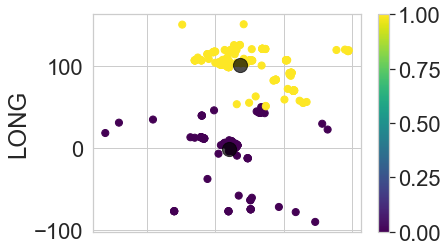

In [47]:
d.plot.scatter(x = 'LAT', 
               y = 'LONG', 
               c = labels, 
               s = 50, 
               cmap = 'viridis')
plt.scatter(centers[:, 0], 
            centers[:, 1], 
            c='black', 
            s=200, 
            alpha=0.7)

In [14]:
centers

array([[  3.96033289,  -0.48914908],
       [  7.1531268 , 101.81741379]])

In [15]:
d = d["cluster_label"]
data = pd.concat([data, d] , axis = 1)

In [16]:
data['weekday'] = data['DATETIME (LOCAL)'].dt.day_name()

In [17]:
data['month'] = data['DATETIME (LOCAL)'].dt.month_name()

In [18]:
data['year'] = data['DATETIME (LOCAL)'].dt.year # only 2 years, 2015 and 201

In [19]:
data['hours'] = data['DATETIME (LOCAL)'].dt.hour

In [20]:
data['VESSEL ACTIVITY LOCATION'].value_counts()

OFF SHORE    283
ANCHORAGE    183
BERTH         41
Name: VESSEL ACTIVITY LOCATION, dtype: int64

In [21]:
# Incident type is a post hoc description that cannot be used in prediction
# MAERSK contains only 8 positive obs. 

In [22]:
# Grouping infrequent categories together
l = data[data.groupby('REGION')['REGION'].transform('size') < 10]['REGION']
for country in l:
    data['REGION'] = np.where(data['REGION'] == country, 'OTHER REGION', data['REGION'])

l = data[data.groupby('COUNTRY')['COUNTRY'].transform('size') < 10]['COUNTRY']
for country in l:
    data['COUNTRY'] = np.where(data['COUNTRY'] == country, 'OTHER COUNTRY', data['COUNTRY'])
    
l = data[data.groupby('VESSEL TYPE')['VESSEL TYPE'].transform('size') < 10]['VESSEL TYPE']
for country in l:
    data['VESSEL TYPE'] = np.where(data['VESSEL TYPE'] == country, 'OTHER VESSEL', data['VESSEL TYPE'])  

In [23]:
X = data[['REGION', 'COUNTRY', 'VESSEL TYPE', 'VESSEL ACTIVITY LOCATION',
         'TIME OF DAY', 'cluster_label', 'weekday', 'month', 'hours']]
y = pd.DataFrame(data['ATTACK SUCCESS'])
hold = 0.1

In [24]:
y

,ATTACK SUCCESS
0,0
1,1
2,0
4,1
5,1
...,...
783,1
785,0
786,1
797,0


In [65]:
# strategy 'constant' simply means filling with the fill_value
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
                                         ]
                                  )
# filling missing values with median and scaling
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())
                                     ]
                              )     

In [66]:
num_vars = [] # numeric vars
cat_vars = ['REGION', 'COUNTRY', 'VESSEL TYPE', 'VESSEL ACTIVITY LOCATION',
            'TIME OF DAY', 'cluster_label', 'weekday', 'month', 'hours'] # from previous attempt

In [67]:
# Next we use the ColumnTransformer to apply the transformations to the correct columns in the dataframe
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_vars),
                                               ('cat', categorical_transformer, cat_vars)
                                              ]
                                )

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=hold, random_state=1)

In [69]:
knn = KNeighborsClassifier(n_neighbors=3)

In [70]:
pip = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', knn)
                       ]
                )

In [31]:
X_train

,REGION,COUNTRY,VESSEL TYPE,VESSEL ACTIVITY LOCATION,TIME OF DAY,cluster_label,weekday,month,hours
370,SOUTH EAST ASIA,INDONESIA,BULK CARRIER,OFF SHORE,NIGHT,1,Saturday,July,2
7,WEST AFRICA,CONGO,PRODUCT TANKER,ANCHORAGE,NIGHT,0,Sunday,January,5
249,SOUTH EAST ASIA,INDONESIA,LPG TANKER,OFF SHORE,NIGHT,1,Thursday,October,3
650,SOUTH AMERICA,OTHER COUNTRY,OTHER VESSEL,ANCHORAGE,NIGHT,0,Monday,February,5
105,WEST AFRICA,NIGERIA,PASSENGER VESSEL,OFF SHORE,MORNING,0,Tuesday,March,7
...,...,...,...,...,...,...,...,...,...
393,SOUTH EAST ASIA,INDONESIA,PRODUCT TANKER,ANCHORAGE,NIGHT,1,Tuesday,June,3
118,SOUTH AMERICA,OTHER COUNTRY,PRODUCT TANKER,ANCHORAGE,EVENING,0,Thursday,April,23
582,SOUTH EAST ASIA,SINGAPORE,BULK CARRIER,OFF SHORE,NIGHT,1,Thursday,March,2
358,SOUTH EAST ASIA,INDONESIA,BULK CARRIER,OFF SHORE,NIGHT,1,Thursday,July,3


In [71]:
pip.fit(X_train, y_train)
predictions = pip.predict(X_test)
pip_score = pip.score(X_test, y_test)
pip_score

/opt/anaconda3/envs/propulsion/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.6666666666666666

In [72]:
params = [
    {
        'classifier': [KNeighborsClassifier()],   
        'classifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [CategoricalNB()],
        'classifier__alpha': [1, 2, 3, 4, 5, 6, 7, 8],
        'classifier__fit_prior': ['True', 'False'],
    },
    {
        'classifier': [SVC()],
        'classifier__C': [np.logspace(start = .1, stop = 5, num = 10)],
        'classifier__random_state': [42],
    }
]

In [75]:
gridsearch = GridSearchCV(pip, params, verbose=1).fit(X_train, np.ravel(y_train))
print('Final score is: ', gridsearch.score(X_test, y_test))

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Final score is:  0.5882352941176471


/opt/anaconda3/envs/propulsion/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: only size-1 arrays can be converted to Python scalars

  FitFailedWarning)
/opt/anaconda3/envs/propulsion/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: only size-1 arrays can be converted to Python scalars

  FitFailedWarning)
/opt/anaconda3/envs/propulsion/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: only size-1 arrays can be converted to Python scalars

  FitFailedWarning)
/opt/anaconda3/envs/propulsion/lib/python3.

In [76]:
gridsearch.best_params_

{'classifier': CategoricalNB(alpha=7, class_prior=None, fit_prior='True'),
 'classifier__alpha': 7,
 'classifier__fit_prior': 'True'}

In [36]:
y_train

,ATTACK SUCCESS
370,1
7,0
249,1
650,0
105,1
...,...
393,1
118,0
582,1
358,0
